# Trying Tesseract Tool

In [2]:
!pip install pytesseract opencv-python

In [3]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

## Initial Approach

In [60]:
import cv2
import pytesseract
import os
import re

image_path = os.path.expanduser(r"C:\Users\hiadi\Downloads\meter1.jpeg") 
image_path2 = os.path.expanduser(r"C:\Users\hiadi\Downloads\meter2.jpg")
image_path3 = os.path.expanduser(r"C:\Users\hiadi\Downloads\emeter3.jpg")
image_path4 = os.path.expanduser(r"C:\Users\hiadi\Downloads\emeter4.jpg")

# Step 1: Load image
image = cv2.imread(image_path3)

# Step 2: Preprocess - convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Optional: Apply adaptive thresholding for better OCR
processed = cv2.adaptiveThreshold(gray, 255,
                                  cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 11, 2)

# Step 3: OCR with Tesseract
custom_config = r'--oem 3 --psm 7'  # Treat image as a single line of text
extracted_text = pytesseract.image_to_string(processed, config=custom_config)

# Step 4: Output result
print("Extracted Meter Reading:")
print(extracted_text.strip())

Extracted Meter Reading:



Failed because the full image contains a lot of non-digit visual clutter,

OCR model got confused without isolating the actual digit region.

## Viewing original image

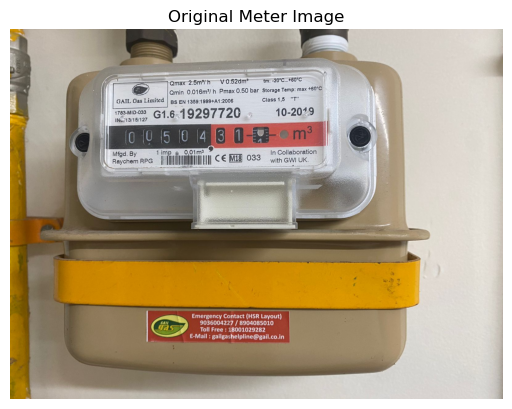

In [8]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.title("Original Meter Image")
plt.show()

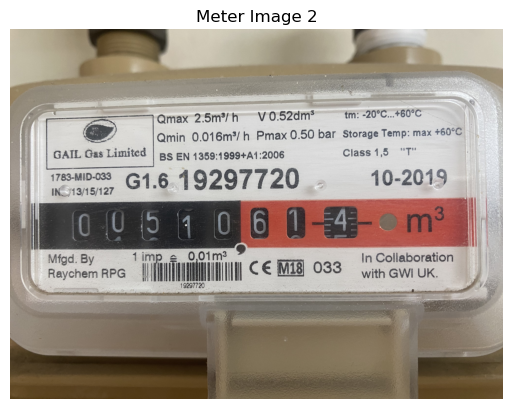

In [58]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread(image_path2)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.title("Meter Image 2")
plt.show()

## Trying to crop to required region

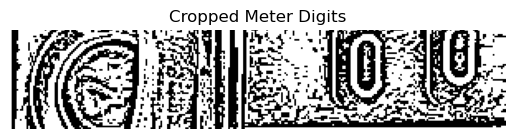

Extracted Meter Reading: 


In [10]:
cropped = image[330:390, 180:480]

# Convert to grayscale
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

# Apply adaptive threshold to clean the digits
thresh = cv2.adaptiveThreshold(gray, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)

# Visualizing cropped + processed image
plt.imshow(thresh, cmap='gray')
plt.axis('off')
plt.title("Cropped Meter Digits")
plt.show()

# OCR with digit whitelist
config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789'
reading = pytesseract.image_to_string(thresh, config=config)

print("Extracted Meter Reading:", reading.strip())

## Extracting all text from Image
Trying to match regex

In [62]:
# Preprocessing: Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Thresholding to make numbers stand out
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# OCR: Extract text from the processed image
custom_config = r'--oem 3 --psm 6'
extracted_text = pytesseract.image_to_string(thresh, config=custom_config)

print("Extracted Text:")
print(extracted_text)

# Using regex to extract a 6-digit meter reading (as seen in the image)
match = re.search(r'\b(\d{6})\b', extracted_text)
if match:
    meter_reading = match.group(1)
    print(f"Meter Reading: {meter_reading} m³")
else:
    print("Meter reading not found.")

Extracted Text:
ar eee
~s + .
iin. “ete e e-- . ™
eno OG: (Dn. we ae “
o nO: “ e 4
Pte oo wes ; . oo ER Le. ~- ty
. +s aN : 2 7
. a iff vont Fay we
. = : . ° <i
- Be Scene ion 4 cere” fe pe \\ ‘
y+ 3 0 Aa er or La = | Tian. tian ree . > '
; Oe a a Care
ee poe e 4 Ls fl pe LAPS fe
LCi oe a . . .
a “ : ! . a4 a ! . \ at + ‘ vit an : -
.
: a) ‘
peta ae) rd Ne.
‘ a, : -» < ; ‘s
+6 as oe
. . . er) : , , . _
\, fie : 7 Rbbe Ria |p &to a
\
1 oe
u ~ Mh -
Y/Y ‘ oO OO . :
—
oo
-- 7 oe
- _—_—
. ~ s . ~
-— : “fy \
—— my /
—_o ~ ‘“ wo Le )
- . A
*

Meter reading not found.


##  Advanced Image Preprocessing

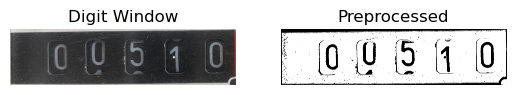

Meter Reading Candidates: []


In [68]:
import cv2
import numpy as np
import pytesseract
import os
from matplotlib import pyplot as plt

image_path = os.path.expanduser(r"C:\Users\hiadi\Downloads\meter2.jpg")

def find_digit_window(img):
    """
    Automatically find the black digit window using color thresholding.
    Returns cropped region containing the digits.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Threshold for dark regions (black window)
    _, mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)
    # Morphology to close gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the largest horizontal rectangle (likely the digit window)
    max_area = 0
    digit_rect = None
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspect = w / float(h)
        if area > max_area and aspect > 3 and h > 20 and w > 100:
            max_area = area
            digit_rect = (x, y, w, h)
    if digit_rect is not None:
        x, y, w, h = digit_rect
        # Add a bit of padding
        pad = 5
        return img[max(y-pad,0):y+h+pad, max(x-pad,0):x+w+pad]
    else:
        raise Exception("Digit window not found!")

def preprocess_for_digits(img):
    """
    Preprocess the cropped digit window for optimal OCR.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    _, thresh = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh = cv2.resize(thresh, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    return thresh

def ocr_digits(img):
    config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789'
    text = pytesseract.image_to_string(img, config=config)
    import re
    matches = re.findall(r'\b\d{6}\b', text)
    return matches

# Load and process the image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

digit_window = find_digit_window(img)
preprocessed = preprocess_for_digits(digit_window)

plt.subplot(1,2,1)
plt.title("Digit Window")
plt.imshow(cv2.cvtColor(digit_window, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1,2,2)
plt.title("Preprocessed")
plt.imshow(preprocessed, cmap='gray')
plt.axis('off')
plt.show()

results = ocr_digits(preprocessed)
print("Meter Reading Candidates:", results)



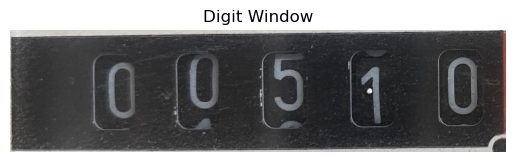

In [56]:
def crop_digit_window(img):
    """
    Crops the region containing all main meter digits (black background, white numbers).
    Coordinates are tuned for your attached image.
    """
    # These coordinates are based on your sample image (meter2.jpg)
    # Adjust as needed for other images
    y1, y2 = 135, 185   # vertical crop (slightly taller)
    x1, x2 = 60, 10000000000000000000000000000    # horizontal crop (much wider to include all digits)
    return img[y1:y2, x1:x2]
plt.imshow(cv2.cvtColor(digit_window, cv2.COLOR_BGR2RGB))
plt.title("Digit Window")
plt.axis('off')
plt.show()


In [38]:
# Usage example
image_path = os.path.expanduser(r"C:\Users\hiadi\Downloads\meter1.jpeg") 
image_path2 = os.path.expanduser(r"C:\Users\hiadi\Downloads\meter2.jpg")
results = advanced_meter_ocr(image_path2)
print("OCR Results:", results)

OCR Results: ['. 5\n. . 7 72\n3\n. 2\n22 13\n018 2 6 4 88\n85 71 .\n7 3 3 2 3 . 0 2 0\n.3 1 4 5 . 4 . 1\n2 2\n2 . 3\n1 8. . 9 2 .\n3 2. 1\n65 2 8 00 0 . ..\n2 . 8 4 8 4\n.9 7 .\n8 123 3 0\n28. . 4\n. 2 4 . .\n5 22 1\n4 3 2\n8 6 2 . . 4\n. 7 . 8. 4 8 54 1\n8 7\n. 7\n. . 5 2 .\n. 2 0 2\n3 . 2\n3\n7 .\n6\n. 5\n20\n2\n.\n2 2\n5 4 . 2', '. .\n. 7 2. .\n. . 3 4 . . . . 20 7 4\n. . . .\n50760\n2498649994412006...10.1\n4 48\n2 7 . . 9\n8 3. 2 3 . 8\n.2\n4 1\n. . .']


# Trying Easy OCR Tool

In [17]:
pip install easyocr

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install --user easyocr

Note: you may need to restart the kernel to use updated packages.


In [20]:
import easyocr
import cv2
import numpy as np

def easyocr_meter_reading(image_path):
    """Use EasyOCR for meter reading"""
    # Initialize EasyOCR reader
    reader = easyocr.Reader(['en'], gpu=False)  # Set gpu=True if you have GPU
    
    # Read image
    img = cv2.imread(image_path)
    
    # Preprocess image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # Use EasyOCR
    results = reader.readtext(enhanced, allowlist='0123456789.')
    
    # Extract text with confidence scores
    readings = []
    for (bbox, text, confidence) in results:
        if confidence > 0.5:  # Filter by confidence
            readings.append((text, confidence))
    
    return readings

# Installation: pip install easyocr
# Usage
image_path = os.path.expanduser(r"C:\Users\hiadi\Downloads\meter1.jpeg") 
readings = easyocr_meter_reading(image_path)
print("EasyOCR Results:", readings)


Using CPU. Note: This module is much faster with a GPU.
C:\Users\hiadi\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


EasyOCR Results: [('10.520', 0.8382410144211723), ('61.6', 0.9998632073402405), ('19297720', 0.9785681447233303), ('10.2019', 0.9016655692782777), ('0103', 0.9141623973846436), ('903600422778904085010', 0.9313838431536149), ('18001029282', 0.9999924519610794), ('13', 0.7179266164773874)]
